### Import libaries for data preparation

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read files

In [19]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [20]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Join tables

In [22]:
movie_ratings = pd.merge(ratings, movies, on="movieId")
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Add rating class

In [23]:
rating_classes = ['very bad', 'bad', 'mediocre', 'good', 'very good']

def assign_rating_class(x):
    if x.rating < 2:
        return 'very bad'
    elif x.rating < 3:
        return 'bad'
    elif x.rating < 4:
        return 'mediocre'
    elif x.rating < 5:
        return 'good'
    return 'very good'

movie_ratings["rating_class"] = movie_ratings.apply(lambda x: assign_rating_class(x), axis=1)
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres,rating_class
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,bad
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good


(0.0, 5.5)

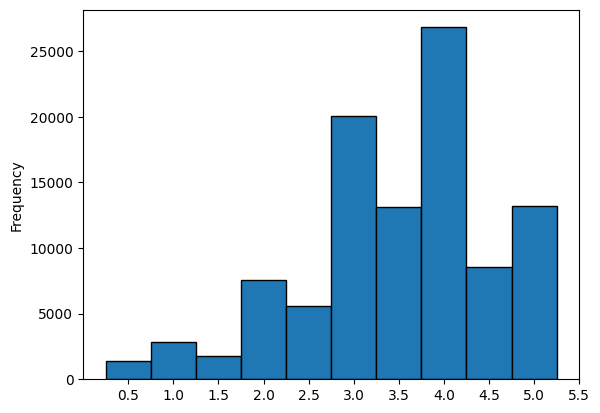

In [24]:
bins = np.arange(0.5, 6, 0.5) - 0.25
movie_ratings.rating.plot(kind='hist', edgecolor="black", bins=bins)
plt.xticks(np.arange(0.5, 6, 0.5))
plt.xlim([0, 5.5])

### Find unique years

In [25]:
import re

# extract years
movie_years = movies.title.str.strip().apply(lambda x: re.findall(r'\(\d+\)$', x)).str[0].str[1:-1]
# remove titles with no year and display their count
movie_mask = [0 if x == x else 1 for x in movie_years]
removed_films = sum(movie_mask)
print(f'Sum of excluded movies: {removed_films}')
movie_years = [int(movie_years[x]) for x in range(len(movie_years)) if movie_mask[x] == 0]

unique_years = set()
for year in movie_years:
    unique_years.add(year)

unique_years = list(unique_years)
unique_years.sort()

Sum of excluded movies: 13


### Create table of users to film rating and year

In [26]:
year_ratings = [str(year) + "|" + rating for year in unique_years for rating in rating_classes]
year_ratings[:5]

['1902|very bad', '1902|bad', '1902|mediocre', '1902|good', '1902|very good']

### Binarize the data

In [27]:
unique_users = ratings.userId.unique()

binary_df = np.zeros((len(unique_users), len(year_ratings)), dtype=np.int8)

for user_id in unique_users:
    user_ratings = movie_ratings.loc[movie_ratings['userId'] == user_id]
    user_movie_years = user_ratings.title.str.strip().apply(lambda x: re.findall(r'\(\d+\)$', x)).str[0].str[1:-1]
    user_movie_ratings = user_ratings.rating_class
    user_movie_year_ratings = set([str(year) + "|" + r_class for year, r_class in zip(user_movie_years, user_movie_ratings)])
    binary_df[user_id-1] = [1 if x in user_movie_year_ratings else 0 for x in year_ratings]

In [28]:
binary_df = pd.DataFrame(binary_df)
binary_df.columns = year_ratings
binary_df = binary_df.astype(bool)
binary_df_users = binary_df.copy()
binary_df_users.insert(0, column="userId", value=unique_users)
binary_df_users.tail(5)

,userId,1902|very bad,1902|bad,1902|mediocre,1902|good,1902|very good,1903|very bad,1903|bad,1903|mediocre,1903|good,...,2017|very bad,2017|bad,2017|mediocre,2017|good,2017|very good,2018|very bad,2018|bad,2018|mediocre,2018|good,2018|very good
605,606,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
606,607,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
607,608,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
608,609,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
609,610,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False


### Run apriori algorithm

In [29]:
from mlxtend.frequent_patterns import apriori

In [35]:
frequent_itemsets = apriori(binary_df, min_support=0.3, use_colnames=True)
print(frequent_itemsets)

      support                                           itemsets
0    0.303279                                        (1980|good)
1    0.301639                                    (1984|mediocre)
2    0.331148                                        (1984|good)
3    0.304918                                        (1985|good)
4    0.314754                                        (1986|good)
..        ...                                                ...
808  0.313115  (1993|good, 1994|good, 1995|mediocre, 1996|goo...
809  0.309836  (1994|very good, 1994|mediocre, 1994|good, 199...
810  0.309836  (1996|mediocre, 1994|mediocre, 1994|good, 1995...
811  0.311475  (1994|mediocre, 1994|good, 1995|mediocre, 1996...
812  0.329508  (1993|good, 1993|mediocre, 1994|mediocre, 1994...

[813 rows x 2 columns]


### Find association rules

In [31]:
from mlxtend.frequent_patterns import association_rules

In [39]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(1990|mediocre),(1994|good),0.401639,0.734426,0.365574,0.910204,1.239340,0.070599,2.957526,0.322747
1,(1991|good),(1994|good),0.488525,0.734426,0.444262,0.909396,1.238240,0.085477,2.931148,0.376171
2,(1992|mediocre),(1994|good),0.375410,0.734426,0.339344,0.903930,1.230798,0.063633,2.764382,0.300227
3,"(1993|mediocre, 1989|mediocre)",(1994|good),0.321311,0.734426,0.304918,0.948980,1.292137,0.068938,5.205246,0.333126
4,"(1993|mediocre, 1989|mediocre)",(1995|mediocre),0.321311,0.654098,0.301639,0.938776,1.435221,0.091470,5.649727,0.446807
...,...,...,...,...,...,...,...,...,...,...
516,"(1993|mediocre, 1994|mediocre, 1994|good, 1995...",(1993|good),0.357377,0.603279,0.329508,0.922018,1.528346,0.113910,5.087367,0.537948
517,"(1993|good, 1994|good, 1993|mediocre, 1994|med...","(1995|good, 1995|mediocre)",0.365574,0.542623,0.329508,0.901345,1.661090,0.131139,4.636140,0.627316
518,"(1993|good, 1993|mediocre, 1994|mediocre, 1995...","(1994|good, 1995|good)",0.355738,0.590164,0.329508,0.926267,1.569508,0.119565,5.558402,0.563214
519,"(1993|good, 1995|good, 1993|mediocre, 1994|med...","(1994|good, 1995|mediocre)",0.355738,0.547541,0.329508,0.926267,1.691686,0.134727,6.136475,0.634639


#### Write results to files

In [40]:
with open("frequent_itemsets.txt", "w") as fi:
    fi.write(frequent_itemsets.to_string())

In [41]:
with open("association_rules.txt", "w") as fr:
    fr.write(rules.to_string())